In [24]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
from IPython.display import display, Markdown
az.style.use('arviz-darkgrid')
import numpy as np
np.random.seed(44)


In [29]:
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 'medium'
plt.rcParams.update({
    'figure.figsize': [12.0, 5.0],
    'figure.constrained_layout.use': True,
    'font.size': 14.0,
    'hist.bins': 'auto',
    'lines.linewidth': 3.0,
    'lines.markeredgewidth': 2.0,
    'lines.markerfacecolor': 'none',
    'lines.markersize': 8.0, 
})

# Gaussian and robust models


Giorgio Corani <br/>
*Bayesian Data Analysis and Probabilistic Programming*
<br/>
<br/>
``giorgio.corani@supsi.ch``





# Based on.. 


*   Chapter 2 of O. Martin, *Bayesian Analysis with Python, Second Edition*.

*  Notebook by G. Corani

# Multiparameter models

* Usually a probabilistic model contains multiple parameters.

* Not all  parameters  are of interest.  If we want to estimate the mean value of a Gaussian distribution the model must contain a parameter for the mean and one for the standard deviation. 

* Parameters that are not of immediate interest but are necessary to  define the model are called *nuisance parameters*.

* By modelling the nuisance parameters we allow the uncertainty  about them to propagate appropriately to the results. 

#  Inference about the speed of light

* At the end of the 19th century Simon Newcomb carried out several experiments to determine the speed of light.
* In each of them, Newcomb measured the time it took for light to travel 7,442 meters.
* The data seems to be normally distributed, apart from some low values far from the mean.


In [30]:
#Below is the results of  66 measurements.

data = np.array([248.28, 248.26, 248.33, 248.24, 248.34, 247.56, 248.27, 248.16,
                  248.4, 247.98, 248.29, 248.22, 248.24, 248.21, 248.25, 248.3,
                  248.23, 248.29, 248.31, 248.19, 248.24, 248.2, 248.36, 248.32,
                  248.36, 248.28, 248.25, 248.21, 248.28, 248.29, 248.37, 248.25,
                  248.28, 248.26, 248.3, 248.32, 248.36, 248.26, 248.3, 248.22,
                  248.36, 248.23, 248.27, 248.27, 248.28, 248.27, 248.31, 248.27,
                  248.26, 248.33, 248.26, 248.32, 248.32, 248.24, 248.39, 248.28,
                  248.24, 248.25, 248.32, 248.25, 248.29, 248.27, 248.28, 248.29,
                  248.16, 248.23])


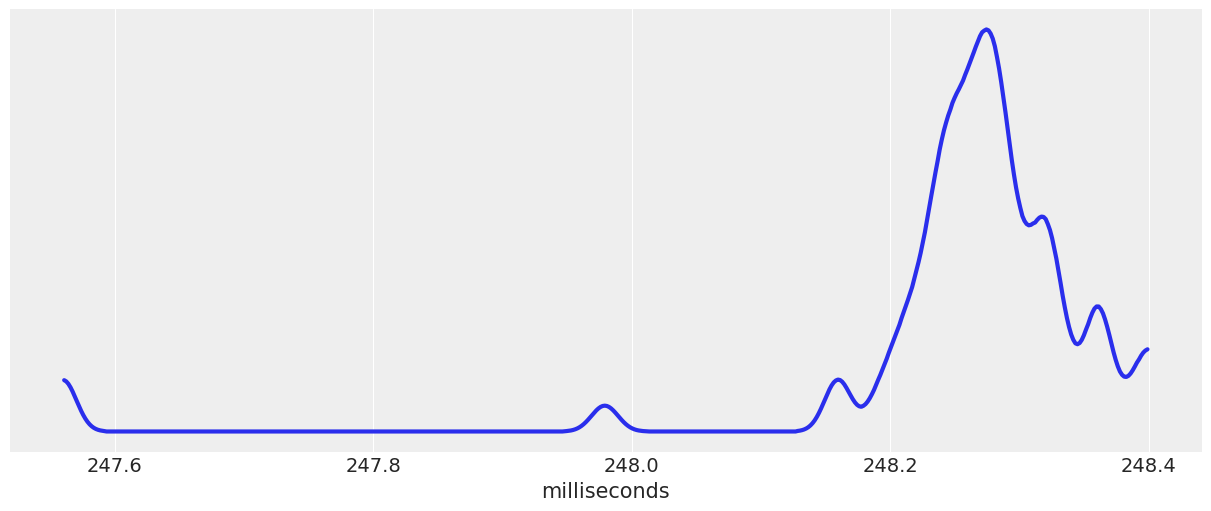

In [31]:
#the density plot is called kde (kernel density estimation)
az.plot_kde(data, figsize=[12,5])
plt.yticks([])
plt.xlabel('milliseconds');

# Gaussian model

* The uncertainty due to measurements error is often Gaussian distributed.

* A Gaussian distribution is defined by  the mean $\mu$ and the standard deviation $\sigma$. 

* To make inference about $\mu$ and $\sigma$ we have to assign priors to them.

# Prior distribution of $\mu$

Before seeing the data, we shall express our -possibly vague- prior belies about the parameters:

* we do not know the exact value of $\mu$, but we can provide an interval which contains it with high probability
    * we can say that e.g. with  95%( or 99%) probability $\mu$ lies within a certain interval ($l$, $u$). 
    * The 95% interval of a Gaussian distribution approximatately comprises  the range $\mu \pm 2 \sigma$
    * We can thus model in this way a Gaussian prior for $\mu$.

* For instance if we believe the mean $\mu$ to lie with 95% probability within the range [0,20], our prior for $\mu
$ is $\mu \sim N(10, 5)$




# Prior distribution of $\sigma$

* A typical prior for  $\sigma$ is the *half-normal* distribution. 
* $\sigma$ is striclty positive.
* The half-normal is  a Gaussian  restricted to positive values . 
* You sample from a half-normal by sampling from a normal distribution and rejecting the negative values (or applying the absolute value to the  sampled values).





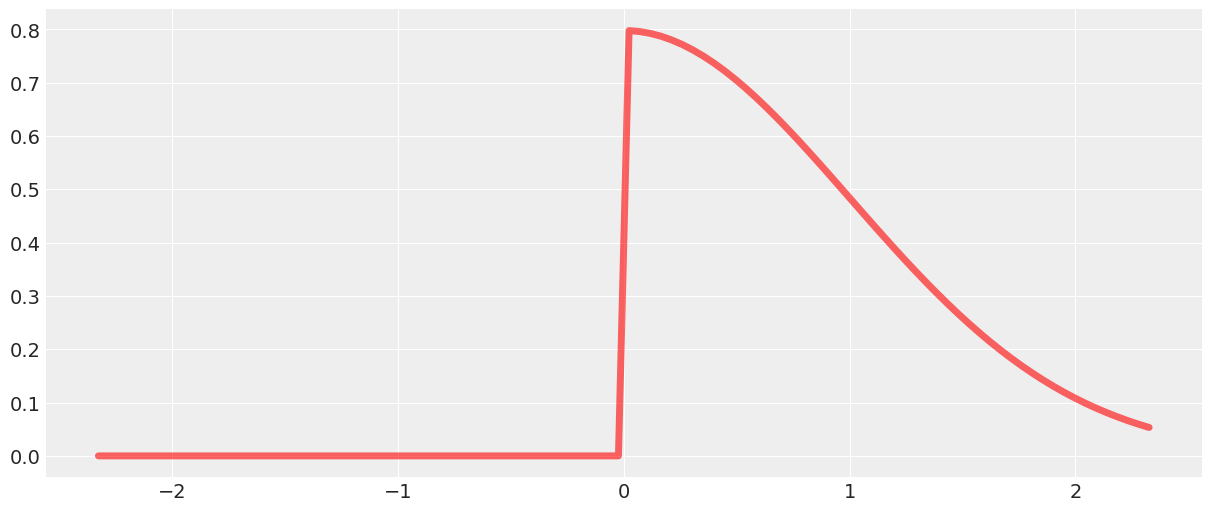

In [32]:
from scipy.stats import norm
from scipy.stats import halfnorm
fig, ax = plt.subplots(1, 1)

#the x are the percentiles 0.01, 0.02, ..,0.99
x = np.linspace(norm.ppf(0.01), norm.ppf(0.99), 100)

#at each x we plot the pdf of the halfnorm
ax.plot(x, halfnorm.pdf(x), 'r-', lw=5, alpha=0.6, label='halfnorm pdf');



# Prior distribution of $\sigma$

* In this case you might have an idea which is a possible value of the standard deviation of the noise, and match it with the median of the half-normal distribution.

* It is important that the prior covers a wide range of plausible values for $\sigma$, leaving out however unreasonable values.

* Usually we play with the scale of the  half-normal distribution to obtain a distribution whose median is close to our guess.

* The distribution is long-tailed and thus it is a safe choice  even if your median guess is underestimated. 


In [33]:
#this might be a sensible choice if you estimate the standard deviation of the noise to be about 7.5.
# That is, with 95% probability your measures are corrupted by an amount of noise betwen +- 15.
#The halfnormal distribution below has median of about 7.5; this has been obtained by trying different values of the scale parameter.
#Notice the long tails of the distribution.
pd.DataFrame(halfnorm.rvs(size=1000, scale=11)).describe()

,0
count,1000.000000
mean,8.802740
std,6.646881
min,0.008884
25%,3.730874
50%,7.462435
75%,12.302741
max,33.810577


# The probabilistic model: priors and likelihood

* The overall *probabilistic model* is :

\begin{align}
y & \sim \mathcal{N}(\mu, \sigma) && \text{the observation are Gaussian}\\
\mu &\sim N(\mu_{\mu}, \sigma_{\mu}) && \text{prior beliefs about } \mu\\ 
\sigma &\sim \text{Half-Normal}(\sigma_{\sigma}) && \text{prior beliefs about } \sigma \\
\end{align}

# Alternative prior for $\mu$ 

\begin{align}
y & \sim \mathcal{N}(\mu, \sigma)\\
\mu &\sim U(l, h) \\
\sigma &\sim \text{Half-Normal}(\sigma_{\sigma}) \\
\end{align}

* We use  priors that reflect our ignorance  about $\mu$ and $\sigma$.

* For the  uniform distribution, we could use:
    * $l$ = 0  (speed cannot be negative)
    * $u$ = 1000 milliseconds (high on the data scale). 

# Alternative (but not recommended) prior for $\mu$

If we have no idea about the possible location of $\mu$, we can use a uniform prior over a large interval: 
\begin{align}
\mu &\sim U(l, h) \\
\sigma &\sim \text{Half-Normal}(\sigma_{\sigma}) \\
y & \sim \mathcal{N}(\mu, \sigma)
\end{align}


* For instance:
    * $l=data.min() / 5$
    * $h=l+data.min() * 5$. 
    
    
* In this way the prior is  much broader then the data.

* However, whenever possible   *avoid* using the data to define the prior.
* Also, prior with sharp limits are to be *avoided* if there is no good reason to sharply limit the variable, as this makes the sampling problematic.
* An example of prior with sharp limits which is appropriate is instead the Beta for the bias $\theta$ of the coin, because $\theta$  is indeed bounded in (0,1).

# Implementation in pyMC3

In [21]:
with pm.Model() as model_newcomb:
    #prior for the location of mu
    # We might believe that mu lies with very high probability in between 0 and 480.
    # This corresponds to a normal distribution with mu = 240 (mid-point of the interval), sigma = 80 
    # obtained as ( (480- 0) / 6)
    # Of course the choice of the prior is subjective. In case of doubt, the important is to make it broad.
    mu = pm.Normal('mu', 240, 80)
    
    #the median sigma according to this prior is about 2.
    #We are hence providing a larger ranger  of values compared to the observerd data. since np.std(data)=0.1. 
    sigma = pm.HalfNormal('sigma', sd=3)

    
    #likelihood. Each observation is a sample from N(mu, sigma).
    y = pm.Normal('y', mu=mu, sd=sigma, observed=data)
    
    trace_newcomb = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


# Inspecting the trace 


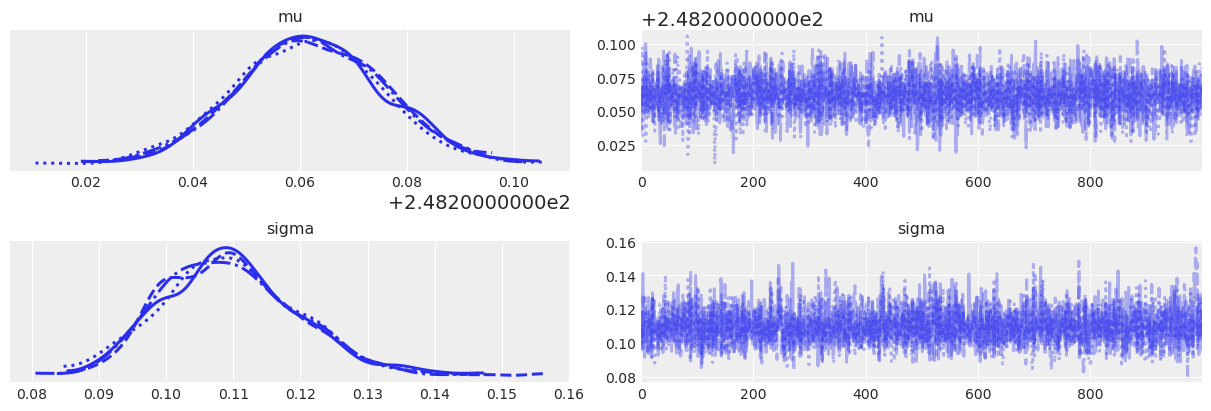

In [34]:
# The traceplot now has two rows: one for each parameter.
#The posterior is  two-dimensional; each  row corresponds to a marginal variable of the posterior.
#The samples are representative as shown by smooth density plot and well-mixing chains.
az.plot_trace(trace_newcomb);

In [35]:
az.summary(trace_newcomb) 

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,248.262,0.013,248.237,248.287,0.0,0.0,2982.0,2387.0,1.0
sigma,0.110,0.010,0.091,0.128,0.0,0.0,2999.0,2450.0,1.0


# What if we change the prior?

In [37]:
with pm.Model() as model_newcomb_2:

    #mu = pm.Normal('mu', 240, 80)
    #we have different beliefs aboout mu; notice also the increased uncertainty.
    mu = pm.Normal('mu', 300, 100)
    
    #as in the previous model
    sigma = pm.HalfNormal('sigma', sd=3)
    y = pm.Normal('y', mu=mu, sd=sigma, observed=data)
    
    trace_newcomb_2 = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


# Checking the effect of the prior

* As we show later, inference remain practically the same under the two different priors.
* This is good: the likelihood overwhelms the prior!
* This happens when the amount of the data is strong enough to converge regardless your priors.
* Your results are thus robust to the specification of the prior.

In [38]:
a = az.summary(trace_newcomb) 
b = az.summary(trace_newcomb_2) 
pd.concat([a,b])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,248.262,0.013,248.237,248.287,0.0,0.0,2982.0,2387.0,1.0
sigma,0.110,0.010,0.091,0.128,0.0,0.0,2999.0,2450.0,1.0
mu,248.262,0.014,248.237,248.289,0.0,0.0,2917.0,2792.0,1.0
sigma,0.110,0.010,0.092,0.128,0.0,0.0,3269.0,2535.0,1.0


# Checking the model: posterior predictive checks

See https://www.bayesrulesbook.com/chapter-9.html#chapter-9-prediction

Once the _a posteriori_ has been computed, we can perform various calculations from it. One such calculation is to _simulate data_ ($\tilde{y}$) as:

\begin{equation}
p(\tilde{y} \,|\, y) = \int p(\tilde{y} \,|\, \theta) \, p(\theta \,|\, y) \, d\theta
\end{equation}


where:

* $y$ is the observed data 
* $\theta$ corresponds to the model parameters.

In our  example, $\theta$ corresponds to the couple of parameters $\mu$ and $\sigma$.

# Posterior predictive checks

We compute  $\tilde{y}$ as follows:

1. We randomly choose an index of the `trace` generated by PyMC3 (a value for $\mu_i$ and $\sigma_i$)
2. We generate a _synthetic data_ using the same _likelihood_ we used in the model, in this case $\tilde{y_i} \sim N(\mu_i, \sigma_i)$
3. We repeat 1 and 2 until we obtain the required number of samples.


# Posterior predictive checks (PPCs)

* PPCs are a way to validate a model. The idea is to generate data sets from the model using the posterior distribution (i.e., the posterior samples) of the parameters.

* PPCs allow analyzing how data generated from the model deviate from actual data.

* This can be used to explain your model to others and revising it (simplifying or expanding it).


# Using the `sample_posterior_predictive` function. 

In [60]:
with model_newcomb:
    #100 samples for each pair of sampled values  <mu_s ,sigma_s> in the trace.
    # Each sample is generated as N()
    #the returned dictionary (ppc) contains 2000 values of y sampled from the posterior of mu and sigma
    ppc = pm.sample_posterior_predictive(trace_newcomb, samples=100)

/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [58]:
# the returned data structure is an xarray
a = az.from_pymc3(posterior_predictive=ppc, model=model_newcomb)

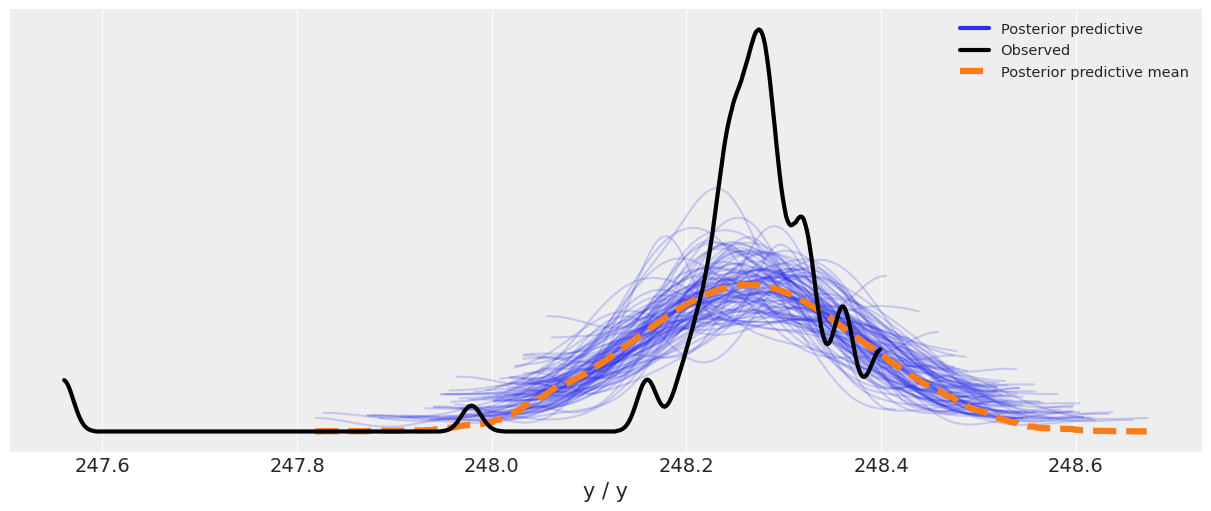

In [59]:
az.plot_ppc(a, kind='kde');

#  Robust models

* The previous model  assumes a normal distribution but there are  outliers  far from the mean values. 

* These points could be due to experimental errors. If we are sure that this is the case,  we could remove them from our dataset (leaving a record of the removal and the reasons why we did it). 

* A more principled approach option is to adopt a model which is *robust* to outliers.

#  Sensitivity of the mean of the normal distribution

* The normal distribution is very sensitive to outliers. 

* Indeed, the probability of finding a value falls rapidly as we move away from the mean, to become practically negligible when we are more than 3-4 standard deviation from the mean.

* In table we show the probability $P = P( \mu - k \sigma < x < \mu + k \sigma) $ 

| k |   \begin{equation} P \end{equation}|
|:-:|:-|
| 1 |  68 |
| 2 | 95  |
| 3 | 99.7 |
| 4 | 99.99 |
| 5 | 99.999 |

# Student's t distribution

* It is defined by a mean, a scale $\sigma$ (related to the spread of the distribution) and by $\nu$ (referred to as *degrees of freedom* in the literature of hypothesis testing).

*  $\nu$ controls how _heavy_ the tails of the distribution are. 

* For $\nu > 30$, the distribution is practically equivalent to a Gaussian. 

* $\nu = 4$ is a common choice to have a robust model with heavy tails.

* The variance is only defined for $\nu > 2$.


<img src='img/Student_t.png' width=400 align="center" > 

# Robustness

* Distance  of some percentiles from the mean.
* The distance is expressed as the number of $\sigma$'s between the percentile and the mean.
* Only some values of $\nu$ are considered

| $\nu$ | Percentile 0.05  | Percentile 0.01
|:-:|:-: | :-:
| 4 | -2.13 | -3.75
| 7 | -1.89 | -3.00
| 10 | -1.81 | -2.76
| 30 | -1.70 | -2.46
| 300 | -1.65 | -2.34



# Robust probabilistic model
Fixing $\nu$=4:

\begin{align}
\mu &\sim U(l, h) \\
\sigma &\sim \mathcal{HN}(\sigma_h) \\
y &\sim StudentT(\mu, \sigma, \nu=4)
\end{align}

* More sophisticated approaches would try to learn $\nu$ from data, by assining a prior to it.

In [67]:
with pm.Model() as model_t:
    # los a prioris
    μ_t = pm.Uniform('μ_t', 240, 250)
    σ_t = pm.HalfNormal('σ_t', sd=1)
    #ν = pm.Exponential('ν', 1/30)
    # el likelihood
    y = pm.StudentT('y', mu=μ_t, sd=σ_t, nu=4, observed=data)
    trace_t = pm.sample(return_inferencedata=True);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ_t, μ_t]
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


/Users/giorgiocorani/opt/anaconda3/envs/r-reticulate/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 90 seconds.


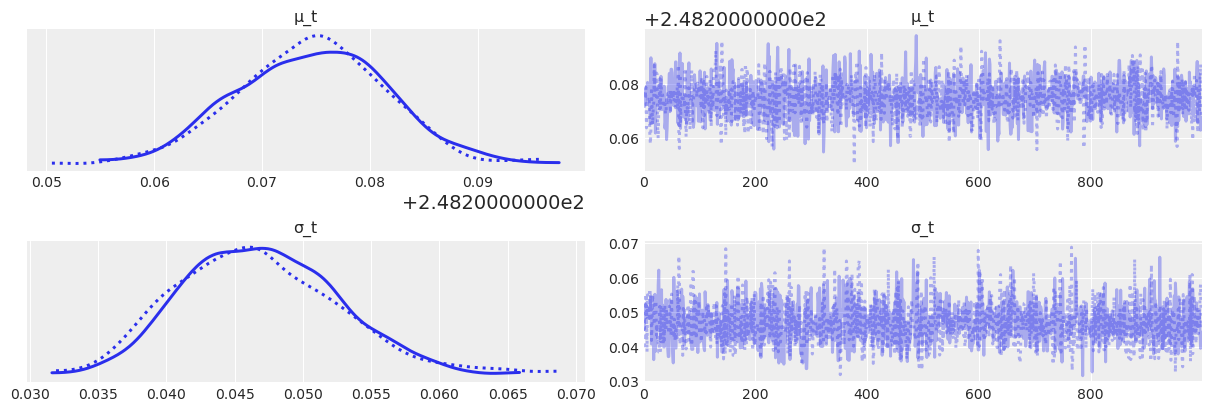

In [68]:
az.plot_trace(trace_t);

# Let us compare the estimates of the two models

In [72]:
pd.concat([az.summary(trace_newcomb),az.summary(trace_t)])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,248.262,0.014,248.236,248.289,0.0,0.0,1678.0,1264.0,1.00
sigma,0.109,0.010,0.092,0.128,0.0,0.0,1627.0,1277.0,1.00
μ_t,248.275,0.007,248.262,248.287,0.0,0.0,1723.0,1503.0,1.00
σ_t,0.047,0.006,0.036,0.057,0.0,0.0,1808.0,1161.0,1.01


# Estimates comparison

* The estimation of estimation of $\mu$ is very similar.

* Both the estimation of $\sigma$ decreases of about half. This is a consequence of the t- distribution giving less weight (being less surprised) by values away from the mean. 

* Let us perform a posterior predictive check.

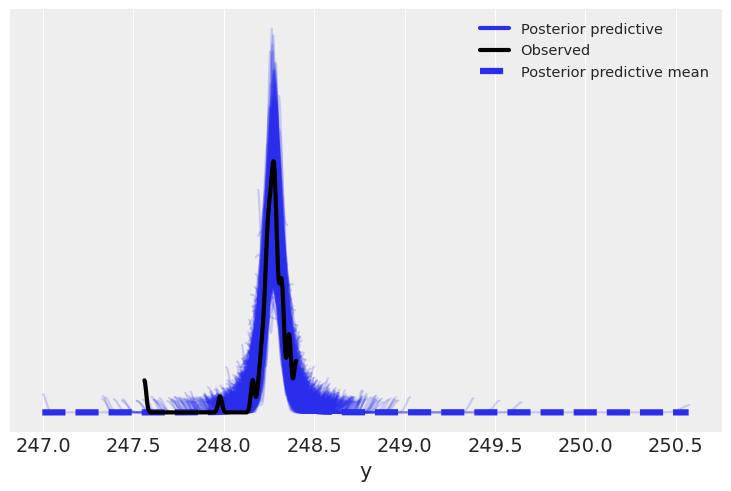

In [73]:
with model_t:
    #by default, 2000 draws of y
    #the returned dictionary (ppc) contains 2000 values of y sampled from the posterior of mu and sigma
    ppc_t = pm.sample_posterior_predictive(trace_t)
    
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc_t, model=model_t));

# Exercises

*  Replace the beta distribution with a uniform one on the interval [0, 1]. How does the sampling rate change? What if you use a wider range, like [-3, 3]?


*  For the `model_g`. Use a Gaussian for the mean, centered at the empirical mean. Try modifying the standard deviation of that prior. How robust/sensitive are the results to the choice of prior?


* The Gaussian is a distribution _without limits_ that is, it is valid in the interval $[-\infty, \infty]$, in the previous example we use it to model data that we know have limits. What do you think of this choice?


* Using the speed of light data, calculate the mean and standard deviation with and without the _outilers_, compare those values ​​with those obtained with the `model_g` and with the `model_t`.
